In [4]:
import numpy as np
import pandas as pd
import os
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import lit, col

In [5]:
import pyspark
myConf = pyspark.SparkConf()
spark = pyspark.sql.SparkSession.builder.getOrCreate()

# 1. Regression(회귀)
- 회귀분석은 입력변수로부터 목표 값을 예측을 하는 문제에 사용합니다.
- 어떤 값을 예측 할 때, 예측할 값과 그 값에 영향을 미치는 변수들이 있습니다.
- 예측 할 값을 **`종속변수(Dependent Variable)`** 또는 **`출력변수(Output Variable)`** 이라고 합니다.
- 영향을 미치는 변수들을 **`독립변수(Independent Variable)`** 또는 **`입력변수(Input Variable)`** 이라고 합니다.
- ex)
    - 영화 매출(종속변수) 예측
        - 영향 미칠수 있는 변수(독립변수)
            - 평점
            - 광고비
            - 투자비
            - 조회수
            - 출연 배우

# 3. 문제
- 온도로부터 회귀식 도출하고, 그래프를 그려보겠습니다.


In [1]:
import numpy as np

x=np.arange(0,9)
y=[19, 20, 20.5, 21.5, 22, 23, 23, 25.5, 24]

In [2]:
A=np.array([x,np.ones(len(x))])

In [4]:
A

array([[0., 1., 2., 3., 4., 5., 6., 7., 8.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1.]])

## 데이터 shape

In [5]:
f"A shape:{A.shape} {A.T.shape}"

'A shape:(2, 9) (9, 2)'

## numpy 회귀식

In [6]:
w=np.linalg.lstsq(A.T, y, rcond=None)[0]

In [7]:
fitted=w[0]*x+w[1]

In [8]:
f"predicted yhat: {fitted}"

'predicted yhat: [19.18888889 19.90555556 20.62222222 21.33888889 22.05555556 22.77222222\n 23.48888889 24.20555556 24.92222222]'

## 그래프
그래프
그래프의 markers는 색, 마커, 선모양으로 설정한다.

- 'bo-'는 줄여서 blue, marker 원, linestyle은 선으로 (linestyle='-', marker='o', color='b')
- 'r.-'는 빨간색으로 점(.)을 선(-)으로 이음.

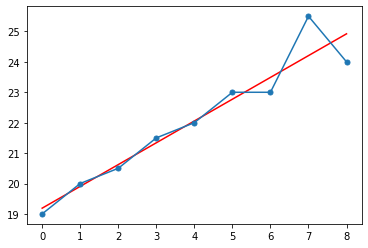

In [10]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

plt.plot(x, fitted,'r-', x,y, 'o-', markersize=5)
plt.show()

# 4. 전복의 나이 예측
- 변수 : sex, length, diameter, height, whole  weight, shucked weight, viscera weight, shell weight, rings
- 종속 변수 : rings
- 나이 age = rings * 1.5

## 4.1 Spark

In [167]:
file_name = "http://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data"

In [168]:
# spark DataFrame은 url에서 읽어서 생성할수 없으므로, pandas로 url 읽어오기
column_names = ["sex", "length", "diameter", "height", "whole weight", 
                "shucked weight", "viscera weight", "shell weight", "rings"]

abalone = pd.read_csv(file_name, names=column_names)
abalone["age"] = 1.5 * abalone["rings"]

### 4.1.0 데이터 불러오기

In [169]:
# DataFrame 생성해주기
abaloneDf = spark.createDataFrame(abalone)
abaloneDf.printSchema()

root
 |-- sex: string (nullable = true)
 |-- length: double (nullable = true)
 |-- diameter: double (nullable = true)
 |-- height: double (nullable = true)
 |-- whole weight: double (nullable = true)
 |-- shucked weight: double (nullable = true)
 |-- viscera weight: double (nullable = true)
 |-- shell weight: double (nullable = true)
 |-- rings: long (nullable = true)
 |-- age: double (nullable = true)



### 4.1.1 훈련, 테스트 데이터 분리

In [170]:
(trainDf, testDf) = abaloneDf.randomSplit([0.6, 0.4])

### 4.1.2 회귀 모델링
- sex는 string으로 설정되어 있어서, stringIndexer를 거쳐 double 타입으로 만들고, onehotencoder 이용해서 vector로 변환해 줍니다.

In [171]:
from pyspark.ml.feature import StringIndexer

stringIndexer = StringIndexer(inputCol="sex", outputCol="sexIndex")

In [172]:
from pyspark.ml.feature import OneHotEncoder
encoder = OneHotEncoder(inputCol="sexIndex", outputCol="sexVec")
#enModel = encoder.fit(trainDf)

In [173]:
from pyspark.ml.feature import VectorAssembler
va = VectorAssembler(inputCols = ["sexVec", "length", "diameter", "height", "whole weight", 
                                            "shucked weight", "viscera weight", "shell weight"],
                                   outputCol = 'features')

In [174]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features', labelCol='age', maxIter=10, regParam=0.3, elasticNetParam=0.8)

In [175]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[stringIndexer, encoder, va, lr])

In [176]:
model = pipeline.fit(trainDf)
modelTrainDf = model.transform(trainDf)

### 4.1.3 예측

In [177]:
modelTestDf=model.transform(testDf)

In [178]:
modelTestDf.select('age','prediction').show(10)

+----+------------------+
| age|        prediction|
+----+------------------+
|12.0|12.669142363987806|
|12.0|12.720591685154687|
|12.0|13.352293770542987|
|13.5|13.434940004454266|
|13.5|14.036333346293564|
|16.5|14.108811170685632|
|12.0|13.179683325321164|
|13.5|13.917645115573112|
|16.5|13.540168463389282|
|15.0|13.803110101047368|
+----+------------------+
only showing top 10 rows



In [179]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator=RegressionEvaluator(labelCol='age', predictionCol="prediction", metricName="r2")

In [180]:
f"r2: {evaluator.evaluate(modelTestDf):.3f}"

'r2: 0.425'

# 5. manhattan house price

## 5.0 Spark

### 5.0.0 데이터 불러오기

In [195]:
# train.csv 파일 불러오기
df = spark.read.format('com.databricks.spark.csv')\
    .options(header='true', inferschema='true')\
    .load(os.path.join("../data/manhattan.csv"))

In [196]:
# 예측에 필요없는 넘버링과, column 제거
#y = df.withColumn('rent',df.rent)
x = df.drop('rental_id').drop('borough')\
#.drop('rent')\
#.drop('neighborhood')
#y = df[['rent']]

### 5.0.1 훈련, 테스트 데이터 분리

In [197]:
# train, test 데이터 나누기
(x_train, x_test) = x.randomSplit([0.8, 0.2])

### 5.0.2 회귀 모델링

In [198]:
# neighborhood StringIndexer 통해서 double 형으로 만들기
from pyspark.ml.feature import StringIndexer

stringIndexer = StringIndexer(inputCol="neighborhood", outputCol="neighborIndex")

In [199]:
# OneHotEncoder 통해서 vector로 변환해 주기
from pyspark.ml.feature import OneHotEncoder

encoder = OneHotEncoder(inputCol="neighborIndex", outputCol="neighborVec")

In [200]:
from pyspark.ml.feature import VectorAssembler

manhattan_col = list(df.columns[2:16])
manhattan_col.append("neighborVec")

va = VectorAssembler(inputCols = manhattan_col, outputCol = 'features')

In [201]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol = 'features', labelCol='rent', maxIter=10, regParam=0.3, elasticNetParam=0.8)

In [202]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[stringIndexer, encoder, va, lr])
#pipeline = Pipeline(stages=[va, lr])

In [203]:
model = pipeline.fit(x_train)
modelTrainDf = model.transform(x_train)

In [204]:
modelTestDf=model.transform(x_test)

In [205]:
modelTestDf.select('rent','prediction').show(10)

+----+-------------------+
|rent|         prediction|
+----+-------------------+
|1300| -706.4529817837038|
|1500|  212.2014830470569|
|1625| 403.61119531718674|
|1662|-207.28405853149587|
|1695| 1645.1889195146136|
|1700| 1686.9771680174044|
|1700|  949.2210575657818|
|1750|  -132.072644724511|
|1775|   855.133054719028|
|1795|  1526.778369113445|
+----+-------------------+
only showing top 10 rows



In [206]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator=RegressionEvaluator(labelCol="rent", predictionCol="prediction", metricName="r2")

In [207]:
f"r2: {evaluator.evaluate(modelTestDf):.3f}"

'r2: 0.798'

In [208]:
# 결정계수 클수록 실제값과 예측값이 유사함을 의미하고, 데이터를 잘 설명한다.